In [95]:
import stim
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

In [66]:
##########################################################
#################### BEGIN GLUE CODE #####################
##########################################################

import math
import networkx as nx
import pymatching
from typing import Callable, List


def predict_observable_errors_using_pymatching(circuit: stim.Circuit,
                                               det_samples: np.ndarray,
                                               ) -> np.ndarray:
    """Turn detection events into predicted observable errors."""
    error_model = circuit.detector_error_model(decompose_errors=True)
    matching_graph = detector_error_model_to_pymatching_graph(error_model)

    num_shots = det_samples.shape[0]
    num_obs = circuit.num_observables
    num_dets = circuit.num_detectors
    assert det_samples.shape[1] == num_dets

    predictions = np.zeros(shape=(num_shots, num_obs), dtype=np.bool8)
    for k in range(num_shots):
        expanded_det = np.resize(det_samples[k], num_dets + 1)
        expanded_det[-1] = 0
        predictions[k] = matching_graph.decode(expanded_det)
    return predictions


def detector_error_model_to_pymatching_graph(model: stim.DetectorErrorModel) -> pymatching.Matching:
    """Convert a stim error model into a pymatching graph."""
    g = detector_error_model_to_nx_graph(model)
    num_detectors = model.num_detectors
    num_observables = model.num_observables

    # Add spandrels to the graph to ensure pymatching will accept it.
    # - Make sure there's only one connected component.
    # - Make sure no detector nodes are skipped.
    # - Make sure no observable nodes are skipped.
    for k in range(num_detectors):
        g.add_node(k)
    g.add_node(num_detectors + 1)
    for k in range(num_detectors + 1):
        g.add_edge(k, num_detectors + 1, weight=9999999999)
    g.add_edge(num_detectors, num_detectors + 1, weight=9999999999, qubit_id=list(range(num_observables)))

    return pymatching.Matching(g)


def detector_error_model_to_nx_graph(model: stim.DetectorErrorModel) -> nx.Graph:
    """Convert a stim error model into a NetworkX graph."""

    g = nx.Graph()
    boundary_node = model.num_detectors
    g.add_node(boundary_node, is_boundary=True, coords=[-1, -1, -1])

    def handle_error(p: float, dets: List[int], frame_changes: List[int]):
        if p == 0:
            return
        if len(dets) == 0:
            # No symptoms for this error.
            # Code probably has distance 1.
            # Accept it and keep going, though of course decoding will probably perform terribly.
            return
        if len(dets) == 1:
            dets = [dets[0], boundary_node]
        if len(dets) > 2:
            raise NotImplementedError(
                f"Error with more than 2 symptoms can't become an edge or boundary edge: {dets!r}.")
        if g.has_edge(*dets):
            edge_data = g.get_edge_data(*dets)
            old_p = edge_data["error_probability"]
            old_frame_changes = edge_data["qubit_id"]
            # If frame changes differ, the code has distance 2; just keep whichever was first.
            if set(old_frame_changes) == set(frame_changes):
                p = p * (1 - old_p) + old_p * (1 - p)
                g.remove_edge(*dets)
        g.add_edge(*dets, weight=math.log((1 - p) / p), qubit_id=frame_changes, error_probability=p)

    def handle_detector_coords(detector: int, coords: np.ndarray):
        g.add_node(detector, coords=coords)

    eval_model(model, handle_error, handle_detector_coords)

    return g


def eval_model(
        model: stim.DetectorErrorModel,
        handle_error: Callable[[float, List[int], List[int]], None],
        handle_detector_coords: Callable[[int, np.ndarray], None]):
    """Interprets the error model instructions, taking care of loops and shifts.

    Makes callbacks as error mechanisms are declared, and also when detector
    coordinate data is declared.
    """
    det_offset = 0
    coords_offset = np.zeros(100, dtype=np.float64)

    def _helper(m: stim.DetectorErrorModel, reps: int):
        nonlocal det_offset
        nonlocal coords_offset
        for _ in range(reps):
            for instruction in m:
                if isinstance(instruction, stim.DemRepeatBlock):
                    _helper(instruction.body_copy(), instruction.repeat_count)
                elif isinstance(instruction, stim.DemInstruction):
                    if instruction.type == "error":
                        dets: List[int] = []
                        frames: List[int] = []
                        t: stim.DemTarget
                        p = instruction.args_copy()[0]
                        for t in instruction.targets_copy():
                            if t.is_relative_detector_id():
                                dets.append(t.val + det_offset)
                            elif t.is_logical_observable_id():
                                frames.append(t.val)
                            elif t.is_separator():
                                # Treat each component of a decomposed error as an independent error.
                                # (Ideally we could configure some sort of correlated analysis; oh well.)
                                handle_error(p, dets, frames)
                                frames = []
                                dets = []
                        # Handle last component.
                        handle_error(p, dets, frames)
                    elif instruction.type == "shift_detectors":
                        det_offset += instruction.targets_copy()[0]
                        a = np.array(instruction.args_copy())
                        coords_offset[:len(a)] += a
                    elif instruction.type == "detector":
                        a = np.array(instruction.args_copy())
                        for t in instruction.targets_copy():
                            handle_detector_coords(t.val + det_offset, a + coords_offset[:len(a)])
                    elif instruction.type == "logical_observable":
                        pass
                    else:
                        raise NotImplementedError()
                else:
                    raise NotImplementedError()
    _helper(model, 1)

##########################################################
##################### END GLUE CODE ######################
##########################################################

## Comparing the two graphs for MWPM dedcoding

In [15]:
repc = stim.Circuit('''
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    X_ERROR(0.5) 0 2

    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

m = detector_error_model_to_pymatching_graph(repc.detector_error_model(decompose_errors=True))
shots = repc.compile_detector_sampler().sample(1, append_observables=True)[0]
observable = shots[-1]
print('observable = ', observable)

# decode using glue code and error model
expanded_det = np.resize(shots[:-1], repc.num_detectors + 1)
expanded_det[-1] = 0
print('error model decode', m.decode(expanded_det))

# decode using matching matrix
detector_events = expanded_det[:-1].reshape(-1, 2)
print(detector_events)
m_matrix = pymatching.Matching([[1, 1, 0], [0, 1, 1]], repetitions=2)
print('matrix decode', m_matrix.decode(detector_events.T))

observable =  0
error model decode [0]
[[0 0]
 [0 1]]
matrix decode [0 0 1]


## Threshold behavior under different simulation conditions

In [67]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True)

    detector_parts = shots[:, :circuit.num_detectors]
    actual_observable_parts = shots[:, circuit.num_detectors:]
    predicted_observable_parts = predict_observable_errors_using_pymatching(circuit, detector_parts)

    num_errors = 0
    for actual, predicted in zip(actual_observable_parts, predicted_observable_parts):
        if not np.array_equal(actual, predicted):
            num_errors += 1
    return num_errors

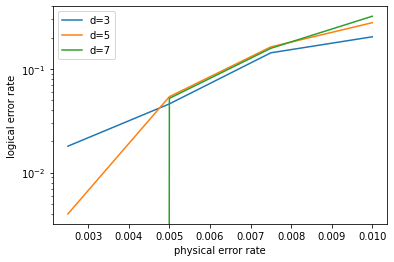

In [68]:
num_shots = 1000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.0025, 0.0050, 0.0075, 0.0100]:
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise)
        xs.append(noise)
        ys.append(count_logical_errors(circuit, num_shots) / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.legend()
plt.show()

In [83]:
def log_err_fit(rounds, e_logical):
    return 0.5*(1 - (1-2*e_logical)**rounds)

    

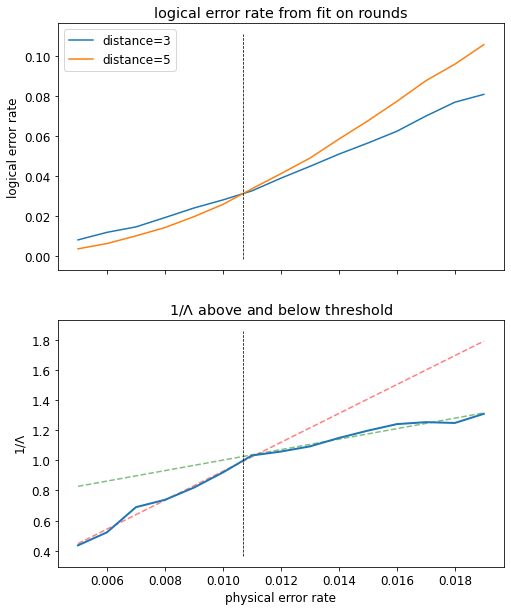

In [130]:
import matplotlib
matplotlib.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 1, sharex='all', figsize=(8,10))

for i, d in enumerate(distance_vec):
    ax[0].plot(noise_vec, e_log_vec[:, i], label=f'distance={d}')

thresh = 0.0107

yl = ax[0].get_ylim()
ax[0].plot([thresh] * 2, yl, 'k--', linewidth=0.75)
ax[0].legend()
ax[0].set_title('logical error rate from fit on rounds')
ax[0].set_ylabel('logical error rate')
# plt.grid('all')

fit_lambda_low = np.polyfit(noise_vec[noise_vec < thresh], inv_lambda_vec[noise_vec < thresh], 1)
fit_lambda_hi = np.polyfit(noise_vec[noise_vec >= thresh], inv_lambda_vec[noise_vec >= thresh], 1)


ax[1].set_title('$1/\Lambda$ above and below threshold')

ax[1].set_xlabel('physical error rate')
ax[1].set_ylabel('$1/\Lambda$')

ax[1].plot(noise_vec, np.polyval(fit_lambda_low, noise_vec), 'r--', alpha=0.5)
ax[1].plot(noise_vec, np.polyval(fit_lambda_hi, noise_vec), 'g--', alpha=0.5)
ax[1].plot(noise_vec, inv_lambda_vec, linewidth=2)
yl = ax[1].get_ylim()
ax[1].plot([thresh] * 2, yl, 'k--', linewidth=0.75)
#plt.grid('all')

100%|██████████| 19/19 [13:28<00:00, 42.53s/it]


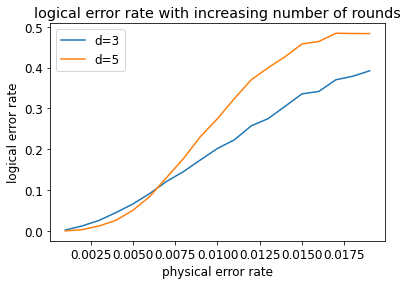

In [141]:
num_shots = 10000
ys = []
for d in [3, 5]:
    xs = []
    ys.append([])
    for noise in tqdm(np.arange(1e-3, 2e-2, 1e-3)):
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise)
        xs.append(noise)
        ys[-1].append(count_logical_errors(circuit, num_shots) / num_shots)
    plt.plot(xs, ys[-1], label="d=" + str(d))
#plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.title('logical error rate with increasing number of rounds')
plt.legend()
plt.show()

In [142]:
repr(ys)

'[[0.0025, 0.0126, 0.0262, 0.0453, 0.0663, 0.0921, 0.1217, 0.1458, 0.1743, 0.2021, 0.2233, 0.2575, 0.2752, 0.3053, 0.3357, 0.3418, 0.3702, 0.3788, 0.3921], [0.0004, 0.0036, 0.0125, 0.0264, 0.051, 0.0847, 0.1315, 0.178, 0.2315, 0.275, 0.3242, 0.3702, 0.3997, 0.4267, 0.4578, 0.4639, 0.484, 0.4834, 0.4831]]'

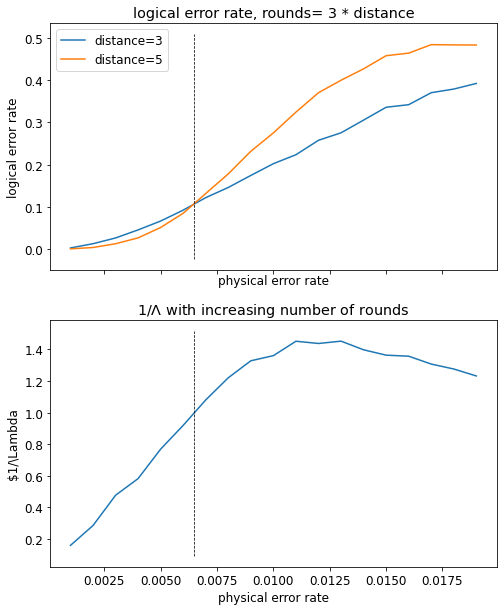

In [181]:
ys = np.array(ys)

thresh = 0.0065

fig, ax = plt.subplots(2, 1, sharex='all', figsize=(8,10))
for i, d in enumerate(distance_vec):
    ax[0].plot(noise_vec, ys[i], label="distance=" + str(d))

yl = ax[0].get_ylim()
ax[0].plot([thresh] * 2, yl, 'k--', linewidth=0.75)

ax[0].set_xlabel("physical error rate")
ax[0].set_ylabel("logical error rate")
ax[0].set_title('logical error rate, rounds= 3 * distance')
ax[0].legend()

ax[1].plot(noise_vec, ys[1, :] / ys[0, :])
ax[1].set_title('$1/\Lambda$ with increasing number of rounds')
ax[1].set_xlabel("physical error rate")
ax[1].set_ylabel('$1/\Lambda')
yl = ax[1].get_ylim()
ax[1].plot([thresh] * 2, yl, 'k--', linewidth=0.75)

  0%|          | 0/19 [00:00<?, ?it/s]

noise=0.001, disance=3, rounds=2
noise=0.001, disance=3, rounds=6
noise=0.001, disance=3, rounds=10
noise=0.001, disance=3, rounds=14
noise=0.001, disance=3, rounds=18
noise=0.001, disance=5, rounds=2
noise=0.001, disance=5, rounds=6
noise=0.001, disance=5, rounds=10
noise=0.001, disance=5, rounds=14
noise=0.001, disance=5, rounds=18


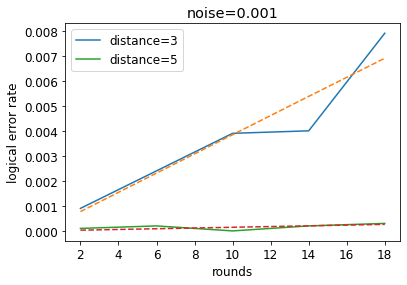

  5%|▌         | 1/19 [00:26<08:02, 26.83s/it]

noise=0.002, disance=3, rounds=2
noise=0.002, disance=3, rounds=6
noise=0.002, disance=3, rounds=10
noise=0.002, disance=3, rounds=14
noise=0.002, disance=3, rounds=18
noise=0.002, disance=5, rounds=2
noise=0.002, disance=5, rounds=6
noise=0.002, disance=5, rounds=10
noise=0.002, disance=5, rounds=14
noise=0.002, disance=5, rounds=18


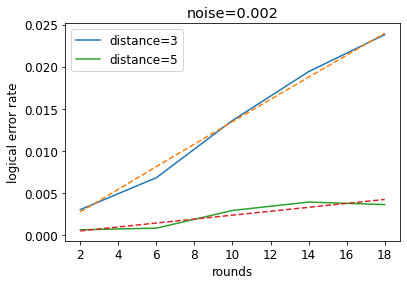

 11%|█         | 2/19 [01:19<09:46, 34.51s/it]

noise=0.003, disance=3, rounds=2
noise=0.003, disance=3, rounds=6
noise=0.003, disance=3, rounds=10
noise=0.003, disance=3, rounds=14
noise=0.003, disance=3, rounds=18
noise=0.003, disance=5, rounds=2
noise=0.003, disance=5, rounds=6
noise=0.003, disance=5, rounds=10
noise=0.003, disance=5, rounds=14
noise=0.003, disance=5, rounds=18


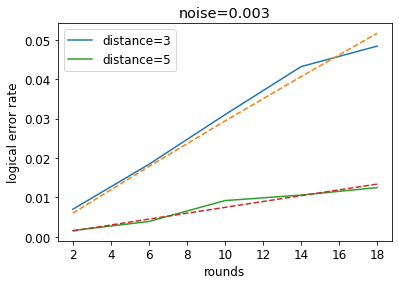

 16%|█▌        | 3/19 [02:35<12:31, 46.98s/it]

noise=0.004, disance=3, rounds=2
noise=0.004, disance=3, rounds=6
noise=0.004, disance=3, rounds=10
noise=0.004, disance=3, rounds=14
noise=0.004, disance=3, rounds=18
noise=0.004, disance=5, rounds=2
noise=0.004, disance=5, rounds=6
noise=0.004, disance=5, rounds=10
noise=0.004, disance=5, rounds=14
noise=0.004, disance=5, rounds=18


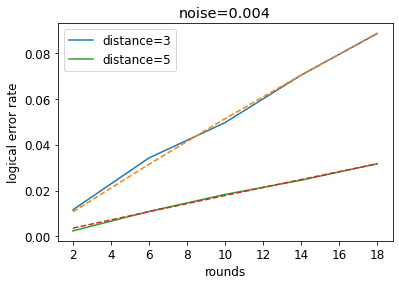

 21%|██        | 4/19 [04:07<15:07, 60.52s/it]

noise=0.005, disance=3, rounds=2
noise=0.005, disance=3, rounds=6
noise=0.005, disance=3, rounds=10
noise=0.005, disance=3, rounds=14
noise=0.005, disance=3, rounds=18
noise=0.005, disance=5, rounds=2
noise=0.005, disance=5, rounds=6
noise=0.005, disance=5, rounds=10
noise=0.005, disance=5, rounds=14
noise=0.005, disance=5, rounds=18


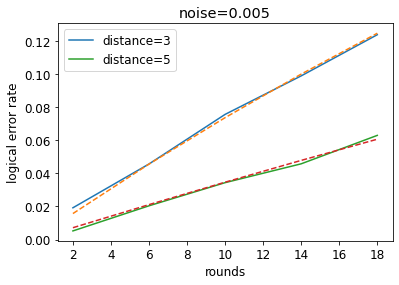

 26%|██▋       | 5/19 [05:53<17:19, 74.22s/it]

noise=0.006, disance=3, rounds=2
noise=0.006, disance=3, rounds=6
noise=0.006, disance=3, rounds=10
noise=0.006, disance=3, rounds=14
noise=0.006, disance=3, rounds=18
noise=0.006, disance=5, rounds=2
noise=0.006, disance=5, rounds=6
noise=0.006, disance=5, rounds=10
noise=0.006, disance=5, rounds=14
noise=0.006, disance=5, rounds=18


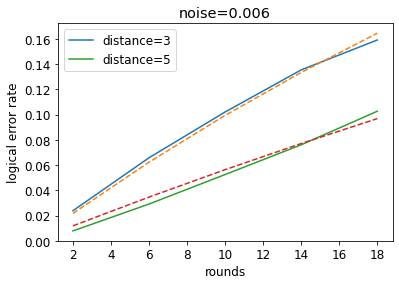

 32%|███▏      | 6/19 [07:55<19:09, 88.42s/it]

noise=0.007, disance=3, rounds=2
noise=0.007, disance=3, rounds=6
noise=0.007, disance=3, rounds=10
noise=0.007, disance=3, rounds=14
noise=0.007, disance=3, rounds=18
noise=0.007, disance=5, rounds=2
noise=0.007, disance=5, rounds=6
noise=0.007, disance=5, rounds=10
noise=0.007, disance=5, rounds=14
noise=0.007, disance=5, rounds=18


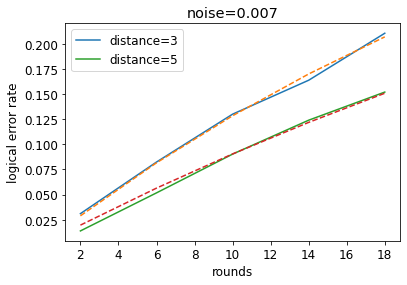

 37%|███▋      | 7/19 [10:09<20:27, 102.32s/it]

noise=0.008, disance=3, rounds=2
noise=0.008, disance=3, rounds=6
noise=0.008, disance=3, rounds=10
noise=0.008, disance=3, rounds=14
noise=0.008, disance=3, rounds=18
noise=0.008, disance=5, rounds=2
noise=0.008, disance=5, rounds=6
noise=0.008, disance=5, rounds=10
noise=0.008, disance=5, rounds=14
noise=0.008, disance=5, rounds=18


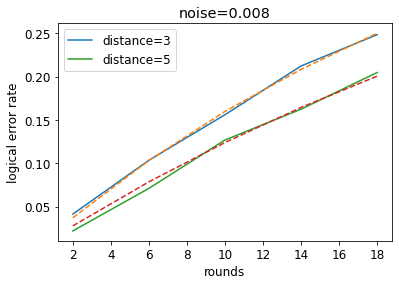

 42%|████▏     | 8/19 [12:33<21:00, 114.59s/it]

noise=0.009000000000000001, disance=3, rounds=2
noise=0.009000000000000001, disance=3, rounds=6
noise=0.009000000000000001, disance=3, rounds=10
noise=0.009000000000000001, disance=3, rounds=14
noise=0.009000000000000001, disance=3, rounds=18
noise=0.009000000000000001, disance=5, rounds=2
noise=0.009000000000000001, disance=5, rounds=6
noise=0.009000000000000001, disance=5, rounds=10
noise=0.009000000000000001, disance=5, rounds=14
noise=0.009000000000000001, disance=5, rounds=18


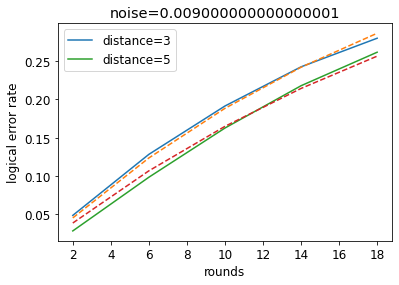

 47%|████▋     | 9/19 [15:06<21:01, 126.14s/it]

noise=0.010000000000000002, disance=3, rounds=2
noise=0.010000000000000002, disance=3, rounds=6
noise=0.010000000000000002, disance=3, rounds=10
noise=0.010000000000000002, disance=3, rounds=14
noise=0.010000000000000002, disance=3, rounds=18
noise=0.010000000000000002, disance=5, rounds=2
noise=0.010000000000000002, disance=5, rounds=6
noise=0.010000000000000002, disance=5, rounds=10
noise=0.010000000000000002, disance=5, rounds=14
noise=0.010000000000000002, disance=5, rounds=18


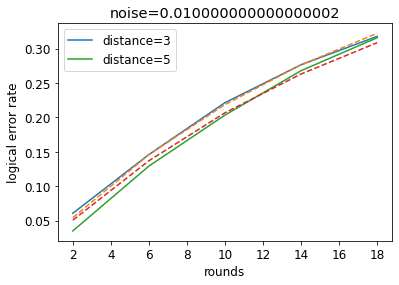

 53%|█████▎    | 10/19 [17:52<20:43, 138.14s/it]

noise=0.011, disance=3, rounds=2
noise=0.011, disance=3, rounds=6
noise=0.011, disance=3, rounds=10
noise=0.011, disance=3, rounds=14
noise=0.011, disance=3, rounds=18
noise=0.011, disance=5, rounds=2
noise=0.011, disance=5, rounds=6
noise=0.011, disance=5, rounds=10
noise=0.011, disance=5, rounds=14
noise=0.011, disance=5, rounds=18


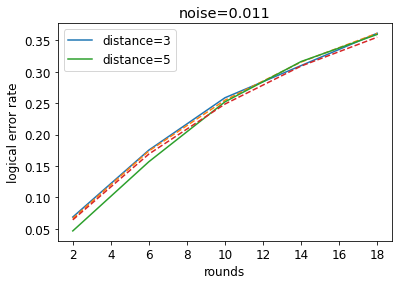

 58%|█████▊    | 11/19 [20:52<20:04, 150.57s/it]

noise=0.012, disance=3, rounds=2
noise=0.012, disance=3, rounds=6
noise=0.012, disance=3, rounds=10
noise=0.012, disance=3, rounds=14
noise=0.012, disance=3, rounds=18
noise=0.012, disance=5, rounds=2
noise=0.012, disance=5, rounds=6
noise=0.012, disance=5, rounds=10
noise=0.012, disance=5, rounds=14
noise=0.012, disance=5, rounds=18


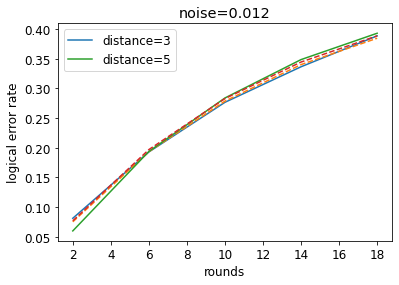

 63%|██████▎   | 12/19 [24:05<19:04, 163.49s/it]

noise=0.013000000000000001, disance=3, rounds=2
noise=0.013000000000000001, disance=3, rounds=6
noise=0.013000000000000001, disance=3, rounds=10
noise=0.013000000000000001, disance=3, rounds=14
noise=0.013000000000000001, disance=3, rounds=18
noise=0.013000000000000001, disance=5, rounds=2
noise=0.013000000000000001, disance=5, rounds=6
noise=0.013000000000000001, disance=5, rounds=10
noise=0.013000000000000001, disance=5, rounds=14
noise=0.013000000000000001, disance=5, rounds=18


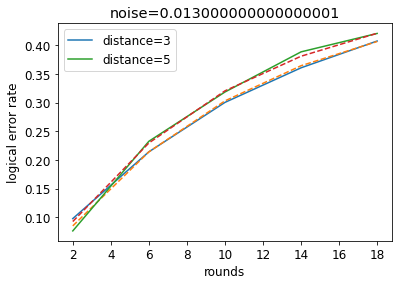

 68%|██████▊   | 13/19 [27:25<17:27, 174.54s/it]

noise=0.014000000000000002, disance=3, rounds=2
noise=0.014000000000000002, disance=3, rounds=6
noise=0.014000000000000002, disance=3, rounds=10
noise=0.014000000000000002, disance=3, rounds=14
noise=0.014000000000000002, disance=3, rounds=18
noise=0.014000000000000002, disance=5, rounds=2
noise=0.014000000000000002, disance=5, rounds=6
noise=0.014000000000000002, disance=5, rounds=10
noise=0.014000000000000002, disance=5, rounds=14
noise=0.014000000000000002, disance=5, rounds=18


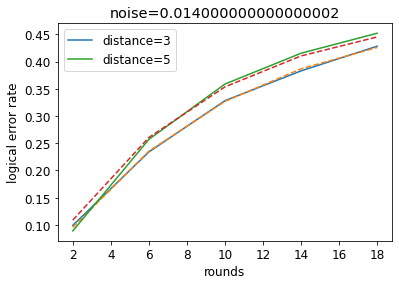

 74%|███████▎  | 14/19 [30:54<15:24, 184.83s/it]

noise=0.015, disance=3, rounds=2
noise=0.015, disance=3, rounds=6
noise=0.015, disance=3, rounds=10
noise=0.015, disance=3, rounds=14
noise=0.015, disance=3, rounds=18
noise=0.015, disance=5, rounds=2
noise=0.015, disance=5, rounds=6
noise=0.015, disance=5, rounds=10
noise=0.015, disance=5, rounds=14
noise=0.015, disance=5, rounds=18


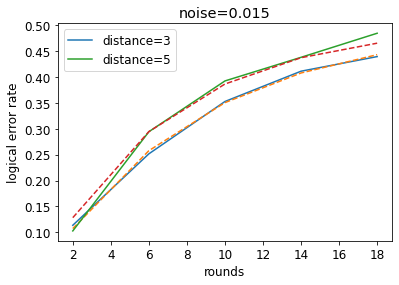

 79%|███████▉  | 15/19 [34:31<12:57, 194.35s/it]

noise=0.016, disance=3, rounds=2
noise=0.016, disance=3, rounds=6
noise=0.016, disance=3, rounds=10
noise=0.016, disance=3, rounds=14
noise=0.016, disance=3, rounds=18
noise=0.016, disance=5, rounds=2
noise=0.016, disance=5, rounds=6
noise=0.016, disance=5, rounds=10
noise=0.016, disance=5, rounds=14
noise=0.016, disance=5, rounds=18


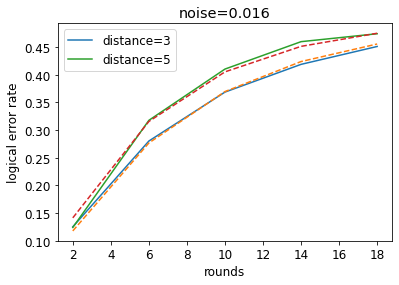

 84%|████████▍ | 16/19 [38:16<10:10, 203.48s/it]

noise=0.017, disance=3, rounds=2
noise=0.017, disance=3, rounds=6
noise=0.017, disance=3, rounds=10
noise=0.017, disance=3, rounds=14
noise=0.017, disance=3, rounds=18
noise=0.017, disance=5, rounds=2
noise=0.017, disance=5, rounds=6
noise=0.017, disance=5, rounds=10
noise=0.017, disance=5, rounds=14
noise=0.017, disance=5, rounds=18


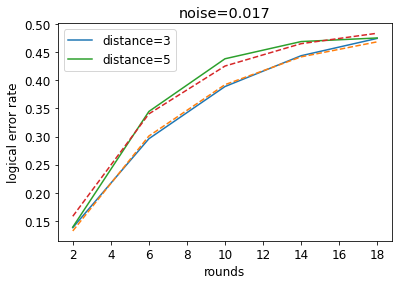

 89%|████████▉ | 17/19 [42:11<07:06, 213.09s/it]

noise=0.018000000000000002, disance=3, rounds=2
noise=0.018000000000000002, disance=3, rounds=6
noise=0.018000000000000002, disance=3, rounds=10
noise=0.018000000000000002, disance=3, rounds=14
noise=0.018000000000000002, disance=3, rounds=18
noise=0.018000000000000002, disance=5, rounds=2
noise=0.018000000000000002, disance=5, rounds=6
noise=0.018000000000000002, disance=5, rounds=10
noise=0.018000000000000002, disance=5, rounds=14
noise=0.018000000000000002, disance=5, rounds=18


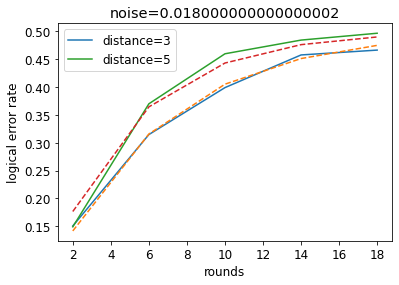

 95%|█████████▍| 18/19 [46:21<03:44, 224.25s/it]

noise=0.019000000000000003, disance=3, rounds=2
noise=0.019000000000000003, disance=3, rounds=6
noise=0.019000000000000003, disance=3, rounds=10
noise=0.019000000000000003, disance=3, rounds=14
noise=0.019000000000000003, disance=3, rounds=18
noise=0.019000000000000003, disance=5, rounds=2
noise=0.019000000000000003, disance=5, rounds=6
noise=0.019000000000000003, disance=5, rounds=10
noise=0.019000000000000003, disance=5, rounds=14
noise=0.019000000000000003, disance=5, rounds=18


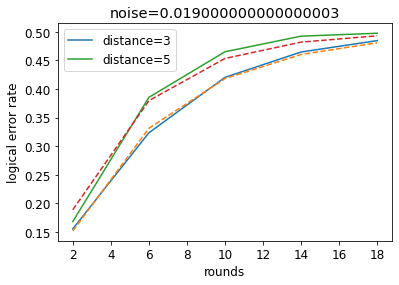

100%|██████████| 19/19 [50:34<00:00, 159.69s/it]


Text(0, 0.5, '1/Lambda')

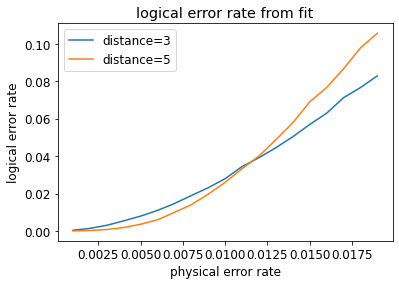

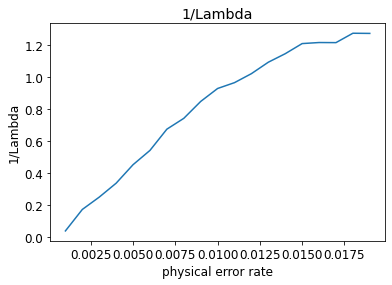

In [183]:
num_shots = 10000
e_log_vec = []
lambda_vec = []
distance_vec = [3, 5]
rounds_vec = np.arange(2, 20, 4)
noise_vec = np.arange(1e-3, 2e-2, 1e-3)
for noise in tqdm(noise_vec):
    plt.figure()
    plt.title(f'noise={noise}')
    ys = []
    zs = []
    e_log_vec.append([])
    for d in [3, 5]:
        zs.append([])
        xs = []
        for rounds in rounds_vec:
            print(f'noise={noise}, disance={d}, rounds={rounds}')
            circuit = stim.Circuit.generated(
                    "surface_code:unrotated_memory_z",
                    rounds=rounds,
                    distance=d,
                    after_clifford_depolarization=noise,
                    after_reset_flip_probability=noise,
                    before_measure_flip_probability=noise,
                    before_round_data_depolarization=noise)
            xs.append(rounds)
            zs[-1].append(count_logical_errors(circuit, num_shots) / num_shots)
        plt.plot(xs, zs[-1], label="distance=" + str(d))
        
        log_err, pcov = curve_fit(log_err_fit, rounds_vec, zs[-1], p0=0)
        plt.plot(rounds_vec, log_err_fit(rounds_vec, log_err), '--')
        e_log_vec[-1].append(log_err)
    
    plt.xlabel("rounds")
    plt.ylabel("logical error rate")
    plt.legend()
    plt.show()

e_log_vec = np.array(e_log_vec)
inv_lambda_vec = e_log_vec[:, 1] / e_log_vec[:, 0]

plt.figure()
for i, d in enumerate(distance_vec):
    plt.plot(noise_vec, e_log_vec[:, i], label=f'distance={d}')
    
plt.legend()
plt.title('logical error rate from fit')
plt.xlabel('physical error rate')
plt.ylabel('logical error rate')

plt.figure()
plt.title('1/Lambda')
plt.plot(noise_vec, inv_lambda_vec)
plt.xlabel('physical error rate')
plt.ylabel('1/Lambda')

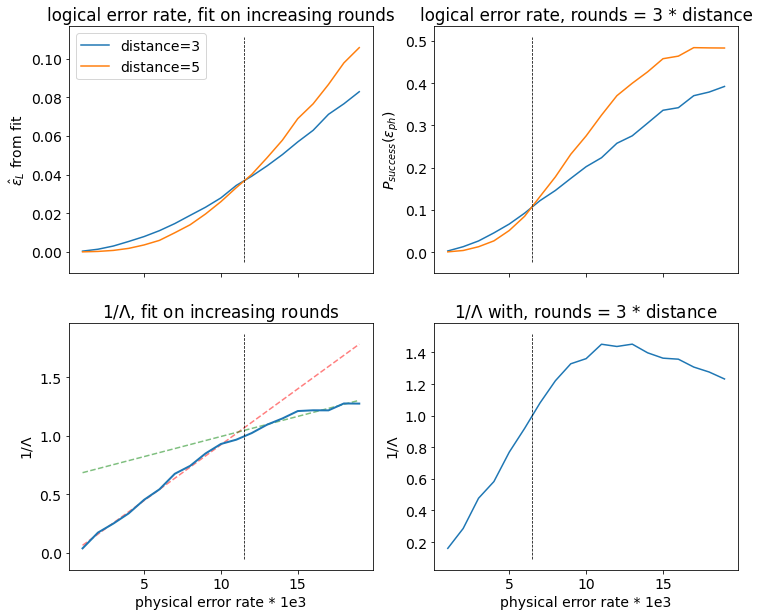

In [216]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
fig, ax = plt.subplots(2, 2, sharex='all', figsize=(12,10))

for i, d in enumerate(distance_vec):
    ax[0, 0].plot(1e3*noise_vec, e_log_vec[:, i], label=f'distance={d}')

thresh = 0.0115

yl = ax[0, 0].get_ylim()
ax[0, 0].plot([1e3*thresh] * 2, yl, 'k--', linewidth=0.75)
ax[0, 0].legend()
ax[0, 0].set_title('logical error rate, fit on increasing rounds')
ax[0, 0].set_ylabel('$\hat{\epsilon}_L$ from fit')
# plt.grid('all')

fit_lambda_low = np.polyfit(noise_vec[noise_vec < thresh], inv_lambda_vec[noise_vec < thresh], 1)
fit_lambda_hi = np.polyfit(noise_vec[noise_vec >= thresh], inv_lambda_vec[noise_vec >= thresh], 1)


ax[1, 0].set_title('$1/\Lambda$, fit on increasing rounds')

ax[1, 0].set_xlabel('physical error rate * 1e3')
ax[1, 0].set_ylabel('$1/\Lambda$')

ax[1, 0].plot(1e3*noise_vec, np.polyval(fit_lambda_low, noise_vec), 'r--', alpha=0.5)
ax[1, 0].plot(1e3*noise_vec, np.polyval(fit_lambda_hi, noise_vec), 'g--', alpha=0.5)
ax[1, 0].plot(1e3*noise_vec, inv_lambda_vec, linewidth=2)
yl = ax[1, 0].get_ylim()
ax[1, 0].plot([1e3*thresh] * 2, yl, 'k--', linewidth=0.75)
#plt.grid('all')

ys = np.array(ys)
for i, d in enumerate(distance_vec):
    ax[0, 1].plot(1e3 * noise_vec, ys[i], label="distance=" + str(d))
yl = ax[0, 1].get_ylim()
thresh = 0.0065
ax[0, 1].plot([1e3 * thresh] * 2, yl, 'k--', linewidth=0.75)
ax[0, 1].set_title('logical error rate, rounds = 3 * distance')
ax[0, 1].set_ylabel('$P_{success}(\epsilon_{ph})$')
ax[1, 1].plot(1e3 * noise_vec, ys[1, :] / ys[0, :])
ax[1, 1].set_title('$1/\Lambda$ with, rounds = 3 * distance')
ax[1, 1].set_xlabel("physical error rate * 1e3")
ax[1, 1].set_ylabel('$1/\Lambda$')
yl = ax[1, 1].get_ylim()
ax[1, 1].plot([1e3 * thresh] * 2, yl, 'k--', linewidth=0.75)

Saving meaningful simulation results...

In [218]:
e_log_vec.squeeze()

array([[3.85921756e-04, 1.45483287e-05],
       [1.36281144e-03, 2.34729238e-04],
       [3.02064915e-03, 7.53504824e-04],
       [5.38344028e-03, 1.81257286e-03],
       [7.91238101e-03, 3.58116657e-03],
       [1.09661189e-02, 5.94518776e-03],
       [1.46364325e-02, 9.88264923e-03],
       [1.88883414e-02, 1.40342533e-02],
       [2.30890772e-02, 1.95999171e-02],
       [2.79169554e-02, 2.59644012e-02],
       [3.43648099e-02, 3.32205524e-02],
       [3.91146451e-02, 4.00154417e-02],
       [4.44568672e-02, 4.86691433e-02],
       [5.03157525e-02, 5.77637799e-02],
       [5.68681658e-02, 6.88928840e-02],
       [6.28671794e-02, 7.65729717e-02],
       [7.11435659e-02, 8.66104485e-02],
       [7.65792058e-02, 9.77314358e-02],
       [8.28290885e-02, 1.05623680e-01]])

In [219]:
ys

array([[2.500e-03, 1.260e-02, 2.620e-02, 4.530e-02, 6.630e-02, 9.210e-02,
        1.217e-01, 1.458e-01, 1.743e-01, 2.021e-01, 2.233e-01, 2.575e-01,
        2.752e-01, 3.053e-01, 3.357e-01, 3.418e-01, 3.702e-01, 3.788e-01,
        3.921e-01],
       [4.000e-04, 3.600e-03, 1.250e-02, 2.640e-02, 5.100e-02, 8.470e-02,
        1.315e-01, 1.780e-01, 2.315e-01, 2.750e-01, 3.242e-01, 3.702e-01,
        3.997e-01, 4.267e-01, 4.578e-01, 4.639e-01, 4.840e-01, 4.834e-01,
        4.831e-01]])